In [1]:
from subprocess import run
from itertools import product
from functools import namedtuple

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
Result = namedtuple('Result', ['n_nodes', 'n_vars', 'n_outputs', 'node_basis_idx', 'node_left_idx', 'node_right_idx', 'node_output_idx'])

AND = (0, 0, 0, 1)
OR = (0, 1, 1, 1)
NOT = (1, 1, 0, 0)

In [3]:
def T(i, b1, b2):
    return 1 + 4*i + 2*b1 + b2

In [4]:
def C(i, k, j, n, N):
    return T(N-1, 1, 1) + 1 + 2*(n+N)*i + (n+N)*k + j

In [5]:
def O(i, j, n, N, m):
        return C(N-1, 1, n+N-1, n, N) + 1 + m*i + j

In [6]:
def V(j, t, n, N, m):
        return O(N-1, m-1, n, N, m) + 1 + 2**n*j + t

In [7]:
def satn(n, N, m, f, basis=[AND, OR, NOT], input_path='sat-input', output_path='sat-output'):
    n_vars = V(n+N-1, 2**n - 1, n, N, m)
    n_rest = (
        (2**4 - len(basis))*N +
        2*sum([1 + (n+i)*(n+i-1)//2 for i in range(N)]) +
        m*(1 + N*(N-1)//2) +
        n*2**n + sum([(n+i)**2 * 2**n * 8 for i in range(N)]) +
        N*m*2**n
    )
    
    with open(input_path, 'w') as sat:
        def write(xs):
            sat.write((' '.join(map(str, xs + [0])) + '\n'))
        sat.write('p cnf {} {}\n'.format(n_vars, n_rest))
        
        for v in product([0, 1], repeat=4):
            if v not in basis:
                for i in range(N):
                    write([
                        (1 - 2*v[j])*T(i, b1, b2)
                        for j, (b1, b2) in enumerate(product([0, 1], repeat = 2))
                    ])
                    
        for i in range(N):
            for k in [0, 1]:
                write([
                    C(i, k, j, n, N)
                    for j in range (n+i)
                ])
                for j1 in range(n+i):
                    for j2 in range(j1):
                        write([-C(i, k, j1, n, N), -C(i, k, j2, n, N)])
                        
        for j in range(m):
            write([
                O(i, j, n, N, m)
                for i in range(N)
            ])
            for i1 in range(N):
                for i2 in range(i1):
                    write([-O(i1, j, n, N, m), - O(i2, j, n, N, m)])
                    
        for t, w in enumerate(product([0, 1], repeat=n)):
            for j in range(n):
                write([(2*w[j] - 1)*V(j, t, n, N, m)])
                
        for i in range(N):
            for j0, j1 in product(range(n+i), repeat=2):
                for t in range(2**n):
                    for t0, t1 in product([0, 1], repeat=2):
                        write([
                            -C(i, 0, j0, n, N), -C(i, 1, j1, n, N),
                            (1 - 2*t0)*V(j0, t, n, N, m), (1 - 2*t1)*V(j1, t, n, N, m),
                            -V(n+i, t, n, N, m), T(i, t0, t1)
                        ])
                        write([
                            -C(i, 0, j0, n, N), -C(i, 1, j1, n, N),
                            (1 - 2*t0)*V(j0, t, n, N, m), (1 - 2*t1)*V(j1, t, n, N, m),
                            V(n+i, t, n, N, m), -T(i, t0, t1)
                        ])
                        
        for i in range(N):
            for k in range(m):
                for t, xs in enumerate(product([0, 1], repeat=n)):
                    write([-O(i, k, n, N, m), (2*f(*xs)[k] - 1)*V(n+i, t, n, N, m)])
                    
    run(['minisat', input_path, output_path])
    
    with open('sat-output') as sat:
        status = sat.readline().strip()
        if status == 'SAT':
            values = dict()
            for code in map(int, sat.readline().split()):
                var_id = abs(code)
                var_val = int(code > 0)
                if var_id != 0:
                    values[var_id] = var_val
                    
            fs = []
            os = []
            i0 = []
            i1 = []
            for i in range(N):
                v = tuple([values[T(i, b1, b2)] for b1, b2 in product([0,1], repeat=2)])
                fs.append(basis.index(v))
                
                for j in range(m):
                    if values[O(i, j, n, N, m)]:
                        os.append(j)
                        break
                else:
                    os.append(None)
                    
                for j in range(n+i):
                    if values[C(i, 0, j, n, N)]:
                        i0.append(j-n)
                        break
                        
                for j in range(n+i):
                    if values[C(i, 1, j, n, N)]:
                        i1.append(j-n)
                        break
                        
            return Result(n_nodes=N, n_vars=n, n_outputs=m, node_basis_idx=fs, node_left_idx=i0, 
                                                          node_right_idx=i1, node_output_idx=os)
        elif status == 'UNSAT':
            return None
        else: 
            raise Exception('Unkhown status: {}'.format(status))

In [8]:
def optimize(n, m, f, basis=[AND, OR, NOT]):
    N = 1
    while satn(n, N, m, f, basis=basis) is None:
        N *= 2
        
    lo = 1
    hi = N
    
    while lo < hi:
        mi = (lo + hi) // 2
        if satn(n, mi, m, f, basis=basis) is None:
            lo = mi + 1
        else:
            hi = mi
            
    return satn(n, hi, m, f, basis=basis)

In [9]:
def plot_graph(res, basis_name, graph_path='res.gv', img_path='res.png'):
    with open(graph_path, 'w') as graph:
        def write(s):
            graph.write(s + '\n')
        write('digraph impl {')
        
        for i in range(res.n_vars):
            write('x{}[shape=circle color=red];'.format(i))
            
        for i in range(res.n_outputs):
            write('y{}[shape=circle color=blue];'.format(i))
            
        for i in range(res.n_nodes):
            write('f{}[shape=invhouse label={}];'.format(i, basis_name[res.node_basis_idx[i]]))
            if res.node_left_idx[i] < 0:
                write('x{}->f{}[label=L];'.format(res.node_left_idx[i]+res.n_vars, i))
            else:
                write('f{}->f{}[label=L];'.format(res.node_left_idx[i], i))
                
            if res.node_right_idx[i] < 0:
                write('x{}->f{}[label=R];'.format(res.node_right_idx[i]+res.n_vars, i))
            else:
                write('f{}->f{}[label=R];'.format(res.node_right_idx[i], i))
            
            if res.node_output_idx[i] is not None:
                write('f{}->y{}[label=R];'.format(i, res.node_output_idx[i]))
                
        write('}')
        
    !dot -Tpng 'res.gv' -o 'res.png'

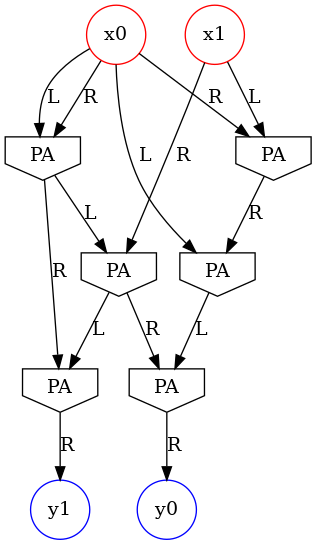

In [13]:
PA = (1, 0, 0, 0)

def f(x, y):
    return (x*y + (1-x)*(1-y), x*y)

res = optimize(2, 2, f, basis=[PA])
plot_graph(res, basis_name=['PA'])
Image.open('res.png')